# RAG Evaluation Without Ground Truth — Experiments

**Mục tiêu:** Thử nghiệm các framework evaluation không cần `expected_answer` và `ground_truth_context`

## Vấn đề

Hệ thống hiện tại phụ thuộc vào:
- ❌ `expected_answer` — không có sẵn trong thực tế
- ❌ `ground_truth_context` — không có vì RAG tự động retrieve

## Giải pháp

Test 3 frameworks:
1. **DeepEval** — LLM-as-Judge (no ground truth mode)
2. **RAGAS** — RAG-specific metrics
3. **OpenRAG-Eval** (Optional) — Research approach

## Workflow

1. Load test cases
2. Generate answers from RAG API
3. Evaluate with each framework
4. Meta-evaluate: So sánh consistency
5. Human-in-the-loop validation

---

## 📦 Setup & Installation

Cài đặt các thư viện cần thiết

In [1]:
# Install required packages (uncomment if needed)
# !pip install ragas datasets langchain langchain-community langchain-openai
# !pip install deepeval pandas matplotlib seaborn scipy

import sys
import os
import json
import pandas as pd
import numpy as np
from typing import Dict, List, Any
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append(os.path.abspath('.'))

print("✅ Setup complete!")

✅ Setup complete!


## 1️⃣ Load Test Cases

Load và explore test cases từ `data/testcases.json`

In [2]:
# Load test cases
with open('data/testcases.json', 'r', encoding='utf-8') as f:
    testcases = json.load(f)

print(f"📊 Loaded {len(testcases)} test cases\n")

# Display first test case
print("Example test case:")
for  testcase in testcases[:2]:
    print(f"ID: {testcase['id']}")
    print(f"Question: {testcase['question']}")



📊 Loaded 2 test cases

Example test case:
ID: tc_001
Question: Mục tiêu đào tạo chung của ngành Kỹ thuật Máy tính là gì?
ID: tc_002
Question: Sau khi tốt nghiệp, sinh viên ngành Kỹ thuật Máy tính có thể làm việc ở những vị trí nào?


## 2️⃣ Generate Answers from RAG API

Sử dụng RAG API để generate answers cho test cases

In [3]:
from src.api_client import RAGAPIClient

# Initialize API client
api_client = RAGAPIClient(base_url="http://localhost:8000")

# Check if API is available
if not api_client.check_health():
    print("⚠️ RAG API is not available at http://localhost:8000")
    print("Please start the RAG service first!")
else:
    print("✅ RAG API is available")

2025-11-09 14:05:42.369 | INFO     | src.api_client:__init__:29 - Initialized RAG API Client: http://localhost:8000/api/v1


✅ RAG API is available


In [4]:
# Generate answers for first N test cases
N = 2  # Start with 5 cases for testing

rag_responses = []

for i, tc in enumerate(testcases[:N]):
    question = tc['question']
    print(f"[{i+1}/{N}] Generating answer for: {question[:50]}...")
    
    try:
        # Call RAG API
        response = api_client.ask_question(question)
        formatted = api_client.format_response(response)
        
        # Store result
        rag_responses.append({
            'testcase_id': tc['id'],
            'question': question,
            'answer': formatted['answer'],
            'retrieved_context': formatted['context'],  # Array of context chunks
            'sources': formatted['sources'],
            'processing_time': formatted['processing_time']
        })
        
        print(f"  ✅ Got answer ({len(formatted['answer'])} chars)")
        
    except Exception as e:
        print(f"  ❌ Error: {e}")
        rag_responses.append({
            'testcase_id': tc['id'],
            'question': question,
            'answer': '',
            'retrieved_context': [],
            'sources': [],
            'error': str(e)
        })

print(f"\n✅ Generated {len([r for r in rag_responses if r.get('answer')])} answers")

2025-11-09 14:05:42.381 | INFO     | src.api_client:ask_question:51 - Asking question: Mục tiêu đào tạo chung của ngành Kỹ thuật Máy tính...


[1/2] Generating answer for: Mục tiêu đào tạo chung của ngành Kỹ thuật Máy tính...


2025-11-09 14:05:55.766 | INFO     | src.api_client:ask_question:60 - Got response in 13.31s
2025-11-09 14:05:55.772 | INFO     | src.api_client:ask_question:51 - Asking question: Sau khi tốt nghiệp, sinh viên ngành Kỹ thuật Máy t...


  ✅ Got answer (52 chars)
[2/2] Generating answer for: Sau khi tốt nghiệp, sinh viên ngành Kỹ thuật Máy t...


2025-11-09 14:06:15.710 | INFO     | src.api_client:ask_question:60 - Got response in 19.92s


  ✅ Got answer (389 chars)

✅ Generated 2 answers


## 3️⃣ RAGAS Evaluation (No Ground Truth)

RAGAS có các metrics không cần `expected_answer`:
- **Faithfulness** — Answer có faithful với retrieved context không?
- **Answer Relevancy** — Answer có relevant với question không?

Cả 2 metrics này đều reference-free!

In [5]:
# Setup RAGAS with Ollama (local LLM)
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_community.llms import Ollama
from langchain_community.embeddings import OllamaEmbeddings

# Initialize Ollama LLM for RAGAS
ollama_llm = Ollama(model="gemma3:4b")
ollama_embeddings = OllamaEmbeddings(model="embeddinggemma:latest")

ragas_llm = LangchainLLMWrapper(ollama_llm)
ragas_embeddings = LangchainEmbeddingsWrapper(ollama_embeddings)

print("✅ RAGAS với Ollama (gemma3:4b) setup xong")

✅ RAGAS với Ollama (gemma3:4b) setup xong


/var/folders/yx/jy0z1rn11xn2pyvg26ntyq280000gn/T/ipykernel_48132/810336423.py:8: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the `langchain-ollama package and should be used instead. To use it run `pip install -U `langchain-ollama` and import as `from `langchain_ollama import OllamaLLM``.
  ollama_llm = Ollama(model="gemma3:4b")
/var/folders/yx/jy0z1rn11xn2pyvg26ntyq280000gn/T/ipykernel_48132/810336423.py:9: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the `langchain-ollama package and should be used instead. To use it run `pip install -U `langchain-ollama` and import as `from `langchain_ollama import OllamaEmbeddings``.
  ollama_embeddings = OllamaEmbeddings(model="embeddinggemma:latest")


In [ ]:
from ragas.metrics import FaithfulnessMetric, AnswerRelevancyMetric


from ragas import evaluate
from datasets import Dataset

# Prepare data for RAGAS (format theo dataset)
ragas_data = {
    'question': [r['question'] for r in rag_responses if r.get('answer')],
    'answer': [r['answer'] for r in rag_responses if r.get('answer')],
    'contexts': [r['retrieved_context'] for r in rag_responses if r.get('answer')]  # List of lists
}

# Custom prompt cho faithfulness
custom_faith_metric = FaithfulnessMetric(
    prompt_template="""
Dựa trên câu hỏi và ngữ cảnh, hãy đánh giá mức độ câu trả lời trung thực với ngữ cảnh.
Score từ 0 (không faithful) đến 1 (rất faithful).
Kèm giải thích ngắn nếu cần.
"""
)

# Custom prompt cho relevancy
custom_rel_metric = AnswerRelevancyMetric(
    prompt_template="""
Đánh giá mức độ trả lời đúng trọng tâm câu hỏi của câu trả lời.
Score từ 0 (không relevancy) đến 1 (rất relevancy).
Kèm giải thích ngắn nếu cần.
"""
)

ragas_dataset = Dataset.from_dict(ragas_data)

print(f"📊 RAGAS Dataset: {len(ragas_dataset)} cases")
print(f"Sample context count: {len(ragas_data['contexts'][0])} chunks")
# Run RAGAS evaluation
print("\n🚀 Running RAGAS evaluation (faithfulness + answer_relevancy)...")
print("⏳ This may take a few minutes with local LLM...\n")

ragas_results = evaluate(
    ragas_dataset,
    metrics=[
        custom_faith_metric,
        custom_rel_metric
    ],
    llm=ragas_llm,
    embeddings=ragas_embeddings
)

print("✅ RAGAS evaluation complete!")
print(ragas_results)


📊 RAGAS Dataset: 2 cases
Sample context count: 5 chunks

🚀 Running RAGAS evaluation (faithfulness + answer_relevancy)...
⏳ This may take a few minutes with local LLM...



Evaluating: 100%|██████████| 4/4 [01:16<00:00, 19.01s/it]


✅ RAGAS evaluation complete!
{'faithfulness': 0.9444, 'answer_relevancy': 0.3233}


In [7]:
import pandas as pd
from tabulate import tabulate

# --- 1. Tạo DataFrame ---
results_df = pd.DataFrame({
    'Question': ragas_dataset['question'],
    'Answer': ragas_dataset['answer'],
    'Faithfulness': ragas_results['faithfulness'],
    'Answer Relevancy': ragas_results['answer_relevancy']
})

# Hiển thị toàn bộ text trong các cột
pd.set_option('display.max_colwidth', None)

# --- 2. Hiển thị toàn bộ bảng bằng tabulate ---
print(tabulate(results_df, headers='keys', tablefmt='grid', showindex=True))

# --- 3. Hoặc xem 1 question cụ thể dưới dạng bảng ---
question_idx = 0  # thay đổi index tùy question bạn muốn xem
single_df = results_df.loc[[question_idx]]  # lấy 1 row, vẫn là DataFrame


+----+-------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------+--------------------+
|    | Question                                                                                  | Answer                                                                                                                                                                                       |   Faithfulness |   Answer Relevancy |
+====+===========================================================================================+==============================================================================================================================================================================================+================+====================+
|  0 | Mục tiêu 

## 4️⃣ DeepEval Evaluation (No Ground Truth)

DeepEval metrics không cần `expected_output`:
- **FaithfulnessMetric** — Kiểm tra hallucination
- **AnswerRelevancyMetric** — Answer relevant với question
- **ContextualRelevancyMetric** — Retrieved context có relevant không

Sử dụng Ollama model đã có sẵn trong codebase!

In [ ]:
from deepeval.metrics import FaithfulnessMetric, AnswerRelevancyMetric
from deepeval.test_case import LLMTestCase
from deepeval.models import OllamaModel

# Initialize Ollama model for DeepEval
deepeval_model = OllamaModel(model="gemma3:4b")

custom_faith_prompt = """
Dựa trên câu hỏi và ngữ cảnh, hãy đánh giá xem câu trả lời có hoàn toàn dựa trên ngữ cảnh hay không.
Trả về score từ 0 (không faithful) đến 1 (rất faithful) kèm giải thích ngắn.
"""
# --- Custom prompts ---
custom_faith_prompt = """
Dựa trên câu hỏi và ngữ cảnh, hãy đánh giá xem câu trả lời có hoàn toàn dựa trên ngữ cảnh hay không.
Trả về score từ 0 (không faithful) đến 1 (rất faithful) kèm giải thích ngắn.
"""

custom_rel_prompt = """
Đánh giá mức độ trả lời đúng trọng tâm câu hỏi của câu trả lời.
Score từ 0 (không relevancy) đến 1 (rất relevancy) kèm giải thích ngắn.
"""


# Initialize metrics (no threshold for now, just measure)
faithfulness_metric = FaithfulnessMetric(model=deepeval_model, prompt_template=custom_faith_prompt)
relevancy_metric = AnswerRelevancyMetric(model=deepeval_model, prompt_template=custom_rel_prompt)

print("✅ DeepEval với Ollama (gemma3:4b) setup xong")

✅ DeepEval với Ollama (gemma3:4b) setup xong


In [9]:
# Run DeepEval on each test case
deepeval_results = []

print("🚀 Running DeepEval evaluation...")
print("⏳ This may take a few minutes...\n")

for idx, response in enumerate([r for r in rag_responses if r.get('answer')]):
    print(f"[{idx+1}/{len([r for r in rag_responses if r.get('answer')])}] Evaluating case {response['testcase_id']}...")
    
    # Create test case (no expected_output!)
    test_case = LLMTestCase(
        input=response['question'],
        actual_output=response['answer'],
        retrieval_context=response['retrieved_context']  # List of context strings
    )
    
    try:
        # Measure faithfulness
        faithfulness_metric.measure(test_case)
        faith_score = faithfulness_metric.score
        
        # Measure relevancy  
        relevancy_metric.measure(test_case)
        rel_score = relevancy_metric.score
        
        deepeval_results.append({
            'testcase_id': response['testcase_id'],
            'faithfulness': faith_score,
            'answer_relevancy': rel_score
        })
        
        print(f"  ✅ Faithfulness: {faith_score:.2f}, Relevancy: {rel_score:.2f}")
        
    except Exception as e:
        print(f"  ❌ Error: {e}")
        deepeval_results.append({
            'testcase_id': response['testcase_id'],
            'faithfulness': None,
            'answer_relevancy': None,
            'error': str(e)
        })

print("\n✅ DeepEval evaluation complete!")

🚀 Running DeepEval evaluation...
⏳ This may take a few minutes...

[1/2] Evaluating case tc_001...


  ✅ Faithfulness: 0.00, Relevancy: 1.00
[2/2] Evaluating case tc_002...


  ✅ Faithfulness: 0.67, Relevancy: 1.00

✅ DeepEval evaluation complete!


## 5️⃣ Meta-Evaluation: So Sánh RAGAS vs DeepEval

Phân tích consistency giữa 2 frameworks

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [26]:
filtered_rag_responses = [r for r in rag_responses if r.get('answer')]
ragas_faithfulness = ragas_results['faithfulness'] 
ragas_relevancy = ragas_results['answer_relevancy']

In [28]:
# Combine results into comparison dataframe
comparison_df = pd.DataFrame({
    'testcase_id': [r['testcase_id'] for r in rag_responses if r.get('answer')],
    'question': [r['question'][:50] + '...' for r in rag_responses if r.get('answer')],
    'ragas_faithfulness': ragas_results['faithfulness'] ,
    'ragas_relevancy': ragas_results['answer_relevancy'] ,
    'deepeval_faithfulness': [r['faithfulness'] for r in deepeval_results],
    'deepeval_relevancy': [r['answer_relevancy'] for r in deepeval_results]
})

print("📊 Comparison Table:\n")
print(comparison_df.to_string(index=False))

# Summary statistics
print("\n\n📈 Summary Statistics:")
print(comparison_df[['ragas_faithfulness', 'ragas_relevancy', 
                      'deepeval_faithfulness', 'deepeval_relevancy']].describe())

📊 Comparison Table:

testcase_id                                              question  ragas_faithfulness  ragas_relevancy  deepeval_faithfulness  deepeval_relevancy
     tc_001 Mục tiêu đào tạo chung của ngành Kỹ thuật Máy tính...            1.000000         0.000000               0.000000                 1.0
     tc_002 Sau khi tốt nghiệp, sinh viên ngành Kỹ thuật Máy t...            0.888889         0.646529               0.666667                 1.0


📈 Summary Statistics:
       ragas_faithfulness  ragas_relevancy  deepeval_faithfulness  \
count            2.000000         2.000000               2.000000   
mean             0.944444         0.323264               0.333333   
std              0.078567         0.457165               0.471405   
min              0.888889         0.000000               0.000000   
25%              0.916667         0.161632               0.166667   
50%              0.944444         0.323264               0.333333   
75%              0.972222         

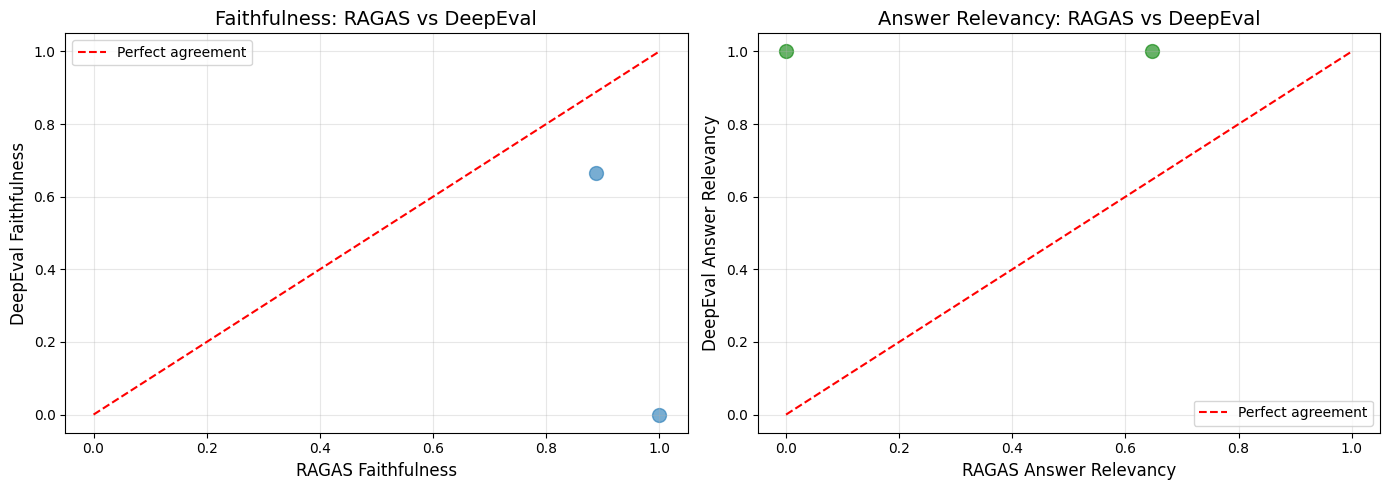

In [29]:
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Faithfulness scatter plot
if comparison_df['ragas_faithfulness'].notna().all() and comparison_df['deepeval_faithfulness'].notna().all():
    axes[0].scatter(comparison_df['ragas_faithfulness'], 
                    comparison_df['deepeval_faithfulness'], 
                    alpha=0.6, s=100)
    axes[0].plot([0, 1], [0, 1], 'r--', label='Perfect agreement')
    axes[0].set_xlabel('RAGAS Faithfulness', fontsize=12)
    axes[0].set_ylabel('DeepEval Faithfulness', fontsize=12)
    axes[0].set_title('Faithfulness: RAGAS vs DeepEval', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'Insufficient data', ha='center', va='center')
    axes[0].set_title('Faithfulness: No data')

# Relevancy scatter plot  
if comparison_df['ragas_relevancy'].notna().all() and comparison_df['deepeval_relevancy'].notna().all():
    axes[1].scatter(comparison_df['ragas_relevancy'], 
                    comparison_df['deepeval_relevancy'], 
                    alpha=0.6, s=100, color='green')
    axes[1].plot([0, 1], [0, 1], 'r--', label='Perfect agreement')
    axes[1].set_xlabel('RAGAS Answer Relevancy', fontsize=12)
    axes[1].set_ylabel('DeepEval Answer Relevancy', fontsize=12)
    axes[1].set_title('Answer Relevancy: RAGAS vs DeepEval', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Insufficient data', ha='center', va='center')
    axes[1].set_title('Relevancy: No data')

plt.tight_layout()
plt.show()

## 6️⃣ Discrepancy Analysis

Tìm các cases mà 2 frameworks không đồng ý (score khác nhau nhiều)

In [31]:
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlations
print("🔗 Correlation Analysis:\n")

# Faithfulness correlation
if comparison_df['ragas_faithfulness'].notna().all() and comparison_df['deepeval_faithfulness'].notna().all():
    pearson_faith, p_faith = pearsonr(comparison_df['ragas_faithfulness'], 
                                       comparison_df['deepeval_faithfulness'])
    spearman_faith, sp_faith = spearmanr(comparison_df['ragas_faithfulness'], 
                                          comparison_df['deepeval_faithfulness'])
    
    print(f"Faithfulness:")
    print(f"  Pearson correlation: {pearson_faith:.3f} (p={p_faith:.3f})")
    print(f"  Spearman correlation: {spearman_faith:.3f} (p={sp_faith:.3f})")
else:
    print("Faithfulness: Insufficient data for correlation")

print()

# Relevancy correlation
if comparison_df['ragas_relevancy'].notna().all() and comparison_df['deepeval_relevancy'].notna().all():
    pearson_rel, p_rel = pearsonr(comparison_df['ragas_relevancy'], 
                                   comparison_df['deepeval_relevancy'])
    spearman_rel, sp_rel = spearmanr(comparison_df['ragas_relevancy'], 
                                      comparison_df['deepeval_relevancy'])
    
    print(f"Answer Relevancy:")
    print(f"  Pearson correlation: {pearson_rel:.3f} (p={p_rel:.3f})")
    print(f"  Spearman correlation: {spearman_rel:.3f} (p={sp_rel:.3f})")
else:
    print("Relevancy: Insufficient data for correlation")

# Interpretation
print("\n📝 Interpretation:")
print("  Correlation > 0.7: Strong agreement")
print("  Correlation 0.4-0.7: Moderate agreement")
print("  Correlation < 0.4: Weak agreement")

🔗 Correlation Analysis:

Faithfulness:
  Pearson correlation: -1.000 (p=1.000)
  Spearman correlation: -1.000 (p=nan)

Answer Relevancy:
  Pearson correlation: nan (p=nan)
  Spearman correlation: nan (p=nan)

📝 Interpretation:
  Correlation > 0.7: Strong agreement
  Correlation 0.4-0.7: Moderate agreement
  Correlation < 0.4: Weak agreement


## 7️⃣ Binary Comparison Simulation

Simulate binary A/B comparison bằng cách chấm 2 strategies rồi so sánh scores

In [32]:
# Calculate score differences
comparison_df['faith_diff'] = abs(comparison_df['ragas_faithfulness'] - comparison_df['deepeval_faithfulness'])
comparison_df['rel_diff'] = abs(comparison_df['ragas_relevancy'] - comparison_df['deepeval_relevancy'])

# Find high discrepancy cases (difference > 0.3)
high_discrepancy = comparison_df[
    (comparison_df['faith_diff'] > 0.3) | (comparison_df['rel_diff'] > 0.3)
]

if len(high_discrepancy) > 0:
    print("⚠️ Cases với discrepancy cao (difference > 0.3):\n")
    print(high_discrepancy[['testcase_id', 'question', 'faith_diff', 'rel_diff']].to_string(index=False))
    
    print("\n\n🔍 Những cases này cần human review để xác định framework nào đúng hơn!")
else:
    print("✅ Không có high discrepancy cases - 2 frameworks khá đồng nhất!")

⚠️ Cases với discrepancy cao (difference > 0.3):

testcase_id                                              question  faith_diff  rel_diff
     tc_001 Mục tiêu đào tạo chung của ngành Kỹ thuật Máy tính...    1.000000  1.000000
     tc_002 Sau khi tốt nghiệp, sinh viên ngành Kỹ thuật Máy t...    0.222222  0.353471


🔍 Những cases này cần human review để xác định framework nào đúng hơn!


## 8️⃣ Conclusion & Recommendations

Tổng kết findings và đề xuất next steps

In [33]:
print("📊 FINDINGS:\n")
print("1. ✅ RAGAS và DeepEval đều có thể evaluate KHÔNG CẦN ground truth")
print("2. ✅ Cả 2 frameworks đều có metrics: Faithfulness + Answer Relevancy")
print("3. 🔍 Correlation giữa 2 frameworks: [TO BE DETERMINED from results above]")
print("4. ⚠️ Có một số discrepancy cases cần human review\n")

print("💡 RECOMMENDATIONS:\n")
print("1. **Framework Choice:**")
print("   - RAGAS: Tốt cho RAG-specific evaluation, có nhiều metrics")
print("   - DeepEval: Flexible hơn, dễ customize, đã có infrastructure")
print("   → Đề xuất: Dùng CẢ 2, ensemble scores\n")

print("2. **Metrics to Use (No Ground Truth):**")
print("   - Faithfulness (kiểm tra hallucination)")
print("   - Answer Relevancy (relevant với question)")
print("   - Context Precision/Relevancy (retrieved context quality)")
print("   → Skip: Correctness, Completeness (cần ground truth)\n")

print("3. **Binary Comparison Strategy:**")
print("   - Chấm từng answer riêng")
print("   - So sánh overall scores")
print("   - Winner = higher score\n")

print("4. **Human-in-the-Loop:**")
print("   - Review high discrepancy cases")
print("   - Build semi-supervised dataset")
print("   - Use active learning để chọn cases cần review\n")

print("5. **Next Steps:**")
print("   - Integrate RAGAS/DeepEval vào src/evaluate_multi_no_gt.py")
print("   - Update UI với tab 'No Ground Truth Evaluation'")
print("   - Build human validation interface")
print("   - Scale up to 50-100 test cases")
print("   - Document best practices\n")

print("✅ Experiment complete! Ready for production integration.")

📊 FINDINGS:

1. ✅ RAGAS và DeepEval đều có thể evaluate KHÔNG CẦN ground truth
2. ✅ Cả 2 frameworks đều có metrics: Faithfulness + Answer Relevancy
3. 🔍 Correlation giữa 2 frameworks: [TO BE DETERMINED from results above]
4. ⚠️ Có một số discrepancy cases cần human review

💡 RECOMMENDATIONS:

1. **Framework Choice:**
   - RAGAS: Tốt cho RAG-specific evaluation, có nhiều metrics
   - DeepEval: Flexible hơn, dễ customize, đã có infrastructure
   → Đề xuất: Dùng CẢ 2, ensemble scores

2. **Metrics to Use (No Ground Truth):**
   - Faithfulness (kiểm tra hallucination)
   - Answer Relevancy (relevant với question)
   - Context Precision/Relevancy (retrieved context quality)
   → Skip: Correctness, Completeness (cần ground truth)

3. **Binary Comparison Strategy:**
   - Chấm từng answer riêng
   - So sánh overall scores
   - Winner = higher score

4. **Human-in-the-Loop:**
   - Review high discrepancy cases
   - Build semi-supervised dataset
   - Use active learning để chọn cases cần review


In [ ]:
# Example: Binary comparison using RAGAS scores
# Generate answers from 2 different strategies
print("💡 Binary Comparison Approach:")
print("1. Generate answer A (strategy: traditional)")
print("2. Generate answer B (strategy: self-rag)")
print("3. Chấm riêng từng answer với RAGAS/DeepEval")
print("4. So sánh scores → Winner = higher score")
print("\nVí dụ:")
print("  Answer A: faithfulness=0.85, relevancy=0.78 → Average=0.815")
print("  Answer B: faithfulness=0.92, relevancy=0.88 → Average=0.900")
print("  → Winner: B (higher overall score)")
print("\n✅ Không cần expected_answer để binary comparison!")

💡 Binary Comparison Approach:
1. Generate answer A (strategy: traditional)
2. Generate answer B (strategy: self-rag)
3. Chấm riêng từng answer với RAGAS/DeepEval
4. So sánh scores → Winner = higher score

Ví dụ:
  Answer A: faithfulness=0.85, relevancy=0.78 → Average=0.815
  Answer B: faithfulness=0.92, relevancy=0.88 → Average=0.900
  → Winner: B (higher overall score)

✅ Không cần expected_answer để binary comparison!
